# Detecting Changeover with Machine Learning using NC Data and external Sensors


## 6-Phases Tuned 

This notebook contains all the preliminary models used in the OBerA project.
It belongs to the article "Detecting Changeover with Machine Learning using NC Data and external Sensors" which can be found in Open Access by the following link: <https://www.mdpi.com/1424-8220/21/17/5896/htm>


## Packages used

Except for imblearn other packages used here are rather common for Anaconda distribution. Most of them are of the newest (or rather new) versions as of August 2021. You shall be able replicate the same results with the newest versions of these packages. However, below the version list of the packages used in the imports will be presented.

*For those interested, a 'requirements.txt' (generated by conda) file with all the packages used within the environment was also added to the project*


conda version : 4.10.3

python version : 3.9.6


pandas==1.3.2

numpy==1.21.2

matplotlib==3.4.3

seaborn==0.11.2

tensorflow==2.6.0

scikit-learn==0.24.2

imbalanced-learn==0.8.0

lightgbm==3.3.2

xgboost==1.5.2

# Imports


In [1]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib as mpl #for visualization
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import tensorflow as tf #for neural networks
from tensorflow import keras #for neural networks
import lightgbm as lgb #for light gradient boosting machine
import xgboost as xgb #for extreme gradient boosting 


# Metrics
from sklearn import metrics #metrics
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores
from sklearn.metrics import ConfusionMatrixDisplay #for plotting confusion matrix

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models
from sklearn.tree import DecisionTreeClassifier #basic decision tree
from tensorflow.keras.optimizers import Adam #optimizer for neural networks
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest classifier
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import ExtraTreesClassifier #extra trees classifier
from sklearn.svm import SVC #support vector machine linear classifier
from catboost import CatBoostClassifier #cat boost classifier

# Data


In [2]:
# Import data from csv
data = pd.read_csv("Data/Cleaned_Data.csv", sep= ',',header=0, index_col=0)
data.head()

,DateTime,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase,Phase_compressed,Production,outlier
0,2021-11-26 07:15:36,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,2000.0,-0.262,0.886,20,4,0,1
1,2021-11-26 07:15:38,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.251,0.840,20,4,0,1
2,2021-11-26 07:15:40,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.234,0.724,20,4,0,1
6358,2021-11-26 07:15:41,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.231,0.741,20,4,0,1
4,2021-11-26 07:15:44,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,2000.0,-0.204,0.731,20,4,0,1


In [3]:
print(data.describe())

       ProgramStatus    ToolNumber   PocketTable   DriveStatus  \
count   20829.000000  20829.000000  20829.000000  20829.000000   
mean        1.416247     11.003217      4.727831      0.518124   
std         1.666373      8.439441      7.276607      0.499683   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.000000      8.000000      0.000000      0.000000   
50%         2.000000      8.000000      0.000000      1.000000   
75%         2.000000     19.000000      8.000000      1.000000   
max         6.000000     32.000000     30.000000      1.000000   

       DoorStatusTooling  OverrideFeed      FeedRate  SpindleSpeed  \
count       20829.000000  20829.000000  20829.000000  20829.000000   
mean            0.041097     85.046090    510.249244   1692.612367   
std             0.198518     33.346662   2894.571722   2514.644846   
min             0.000000      0.000000 -32536.000000      0.000000   
25%             0.000000     81.000000      0.000000   

# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [4]:
# Dropping the columns we do not need
df = data.copy()
df.pop('DateTime')
df.pop('Phase')
df.pop('Production')
df.pop('outlier')
df['Phase_compressed']=df['Phase_compressed']-1
print(df)

       ProgramStatus  ToolNumber  PocketTable  DriveStatus  DoorStatusTooling  \
0                2.0         1.0          1.0          1.0                0.0   
1                2.0         1.0          1.0          1.0                0.0   
2                2.0         1.0          1.0          1.0                0.0   
6358             2.0         1.0          1.0          1.0                0.0   
4                2.0         1.0          1.0          1.0                0.0   
...              ...         ...          ...          ...                ...   
11002            0.0         8.0          8.0          0.0                0.0   
11003            0.0         8.0          8.0          0.0                0.0   
12252            0.0         8.0          8.0          0.0                0.0   
11004            0.0         8.0          8.0          0.0                0.0   
11005            0.0         8.0          8.0          0.0                0.0   

       OverrideFeed  FeedRa

# Data description


In [5]:
# Using the describe function to get 'raw' insights
df.describe()

,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase_compressed
count,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000
mean,1.416247,11.003217,4.727831,0.518124,0.041097,85.046090,510.249244,1692.612367,-0.480892,1.454996,2.904700
std,1.666373,8.439441,7.276607,0.499683,0.198518,33.346662,2894.571722,2514.644846,0.286149,0.941641,1.563087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32536.000000,0.000000,-1.304000,-0.783000,0.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000,81.000000,0.000000,0.000000,-0.697000,0.626000,1.000000
50%,2.000000,8.000000,0.000000,1.000000,0.000000,100.000000,0.000000,0.000000,-0.485000,1.508000,4.000000
75%,2.000000,19.000000,8.000000,1.000000,0.000000,100.000000,310.000000,4599.000000,-0.268000,1.914000,4.000000
max,6.000000,32.000000,30.000000,1.000000,1.000000,150.000000,32732.000000,10046.000000,0.178000,4.877000,5.000000


Text(0.5, 1.0, 'Correlation Heatmap')

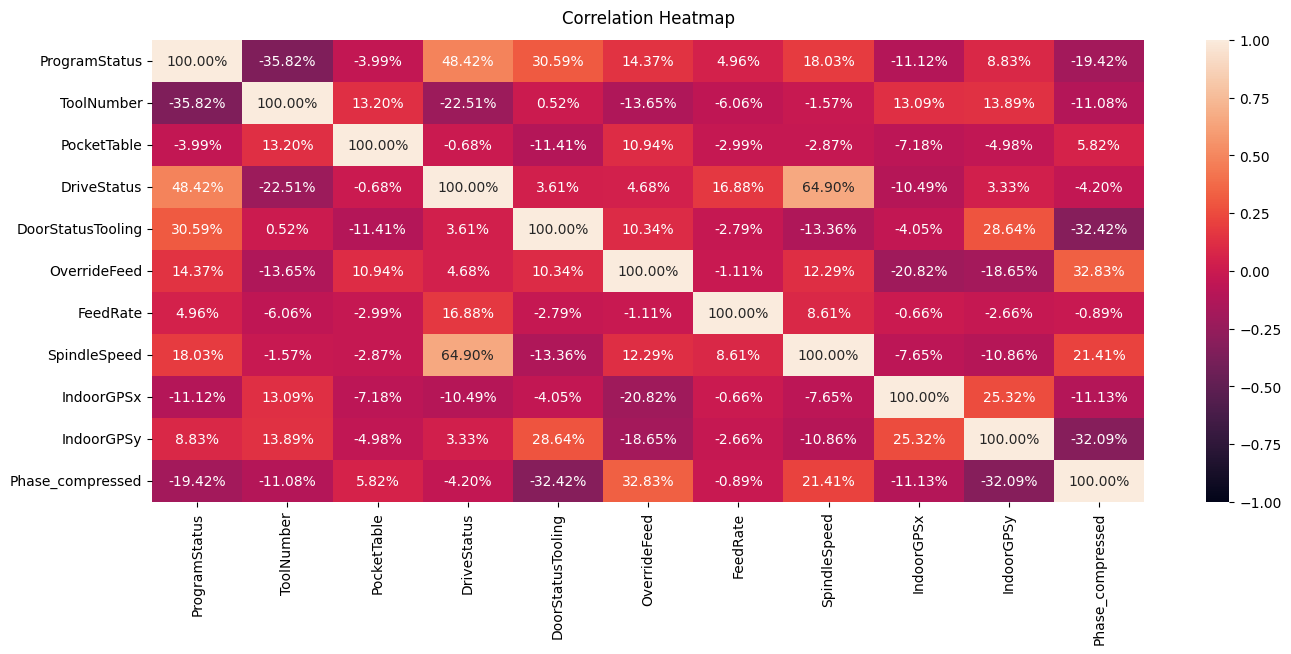

In [6]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [7]:
# Splitting the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df['Phase_compressed'])
test_labels = np.array(test_df['Phase_compressed'])
train_features = np.array(train_df.iloc[:, 0:10])
test_features = np.array(test_df.iloc[:, 0:10])

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Having a look at the results
print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (16663,)
Test labels shape: (4166,)
Training features shape: (16663, 10)
Test features shape: (4166, 10)


In [8]:
train_labels

array([3, 4, 3, ..., 1, 3, 1], dtype=int64)

# Decision Tree


In [9]:
# Create a Decision Tree classifier object
clf_DT = DecisionTreeClassifier(random_state=0)

# Train Decision Tree Classifier
clf_DT = clf_DT.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_DT = clf_DT.predict(test_features)

In [10]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_DT))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       493
           1       0.88      0.90      0.89       691
           2       0.71      0.71      0.71       126
           3       0.89      0.85      0.87       492
           4       0.99      0.99      0.99      2191
           5       0.69      0.66      0.68       173

    accuracy                           0.92      4166
   macro avg       0.83      0.83      0.83      4166
weighted avg       0.92      0.92      0.92      4166



In [11]:
# Get macro average F1 score
f1_DT = f1_score(test_labels, y_pred_DT, average='macro')
f1_DT

0.8312326874854225

In [12]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_DT = matthews_corrcoef(test_labels, y_pred_DT)
MCC_DT

0.8846001830873443

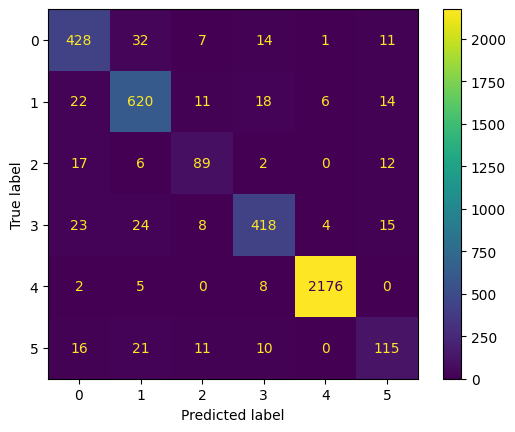

In [13]:
# Plot the confusion matrix for the Decision Tree
cm=confusion_matrix(test_labels,y_pred_DT,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# Neural Network


In [14]:
##split data in training and test data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2,random_state=0)
train_NN_df, validation_df = train_test_split(train_df, test_size=0.125, random_state=0)

# Using numpy to create arrays of lables and features
train_NN_labels = np.array(train_NN_df['Phase_compressed'])
validation_NN_labels = np.array(validation_df['Phase_compressed'])
train_NN_features = np.array(train_NN_df.iloc[:, 0:10])
validation_NN_features = np.array(validation_df.iloc[:, 0:10])

# Form np arrays of labels and features.
test_NN_labels = np.array(test_df['Phase_compressed'])
test_NN_features = np.array(test_df.iloc[:, 0:10])

scaler = StandardScaler()
train_NN_features = scaler.fit_transform(train_NN_features)
test_NN_features = scaler.transform(test_NN_features)
validation_NN_features = scaler.transform(validation_NN_features)

print('Training labels shape:', train_NN_labels.shape)
print('Test labels shape:', test_NN_labels.shape)
print('Validation labels shape:', validation_NN_labels.shape)
print('Training features shape:', train_NN_features.shape)
print('Test features shape:', test_NN_features.shape)
print('Validation features shape:', validation_NN_features.shape)



Training labels shape: (14580,)
Test labels shape: (4166,)
Validation labels shape: (2083,)
Training features shape: (14580, 10)
Test features shape: (4166, 10)
Validation features shape: (2083, 10)


In [25]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Nadam


def create_nn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation='tanh', input_shape=(10,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2), # Prävention von Overfitting
        tf.keras.layers.Dense(40, activation='linear'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    #opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.01), metrics=['accuracy'])
    
    return model


clf_NN = KerasClassifier(model=create_nn_model, metrics=['accuracy'])

history = clf_NN.fit(train_NN_features,train_NN_labels, epochs=90, batch_size=32,validation_data=(validation_NN_features, validation_NN_labels))
# Predict the response for the test dataset
y_pred_NN = clf_NN.predict(test_NN_features,verbose=0)


Epoch 1/90
456/456 [==============================] - 3s 3ms/step - loss: 0.8342 - accuracy: 0.7168 - val_loss: 0.6634 - val_accuracy: 0.7873
Epoch 2/90
456/456 [==============================] - 1s 3ms/step - loss: 0.5696 - accuracy: 0.7903 - val_loss: 0.4653 - val_accuracy: 0.8253
Epoch 3/90
456/456 [==============================] - 1s 3ms/step - loss: 0.5036 - accuracy: 0.8149 - val_loss: 0.4110 - val_accuracy: 0.8569
Epoch 4/90
456/456 [==============================] - 1s 3ms/step - loss: 0.4689 - accuracy: 0.8298 - val_loss: 0.3755 - val_accuracy: 0.8598
Epoch 5/90
456/456 [==============================] - 1s 3ms/step - loss: 0.4463 - accuracy: 0.8369 - val_loss: 0.3516 - val_accuracy: 0.8742
Epoch 6/90
456/456 [==============================] - 1s 3ms/step - loss: 0.4249 - accuracy: 0.8479 - val_loss: 0.3377 - val_accuracy: 0.8713
Epoch 7/90
456/456 [==============================] - 1s 3ms/step - loss: 0.4099 - accuracy: 0.8534 - val_loss: 0.3322 - val_accuracy: 0.8752
Epoch 

In [26]:
# Predicted values as integers
print(y_pred_NN)

[1 0 4 ... 4 1 1]


In [27]:
# Get the metrics for the Neural Network
print(classification_report(test_NN_labels,y_pred_NN))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       493
           1       0.87      0.87      0.87       691
           2       0.71      0.77      0.74       126
           3       0.90      0.88      0.89       492
           4       0.99      0.99      0.99      2191
           5       0.59      0.69      0.64       173

    accuracy                           0.92      4166
   macro avg       0.82      0.83      0.83      4166
weighted avg       0.92      0.92      0.92      4166



In [29]:
# Get macro average F1 score
f1_NN = f1_score(test_NN_labels, y_pred_NN, average='macro')
f1_NN

0.8265290689713507

In [30]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_NN = matthews_corrcoef(test_NN_labels, y_pred_NN)
MCC_NN

0.8754950586563823

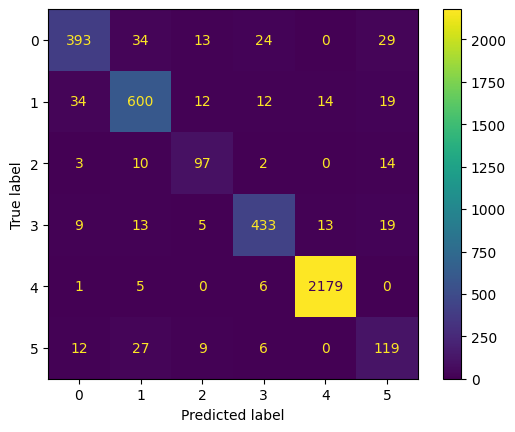

In [31]:
# Plot the confusion matrix for the Neural Network
cm=confusion_matrix(test_NN_labels,y_pred_NN,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# Balanced Random Forest


In [32]:
# Create a Balanced Random Forest classifier object
clf_BRF = BalancedRandomForestClassifier(random_state=42,replacement=True,bootstrap=True,criterion='entropy',
                                         max_depth=23,max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
                                         n_estimators=156,sampling_strategy='not minority')

# Train the Balanced Random Forest Classifier
clf_BRF = clf_BRF.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_BRF = clf_BRF.predict(test_features)

In [33]:
# Get the metrics for the Balanced Random Forest
print(classification_report(test_labels,y_pred_BRF))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       493
           1       0.88      0.87      0.88       691
           2       0.64      0.91      0.75       126
           3       0.94      0.86      0.90       492
           4       0.99      0.99      0.99      2191
           5       0.66      0.80      0.72       173

    accuracy                           0.93      4166
   macro avg       0.83      0.88      0.85      4166
weighted avg       0.93      0.93      0.93      4166



In [34]:
# Get macro average F1 score
f1_BRF = f1_score(test_labels, y_pred_BRF, average='macro')
f1_BRF

0.8501604710015941

In [35]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_BRF = matthews_corrcoef(test_labels, y_pred_BRF)
MCC_BRF

0.8888569285508483

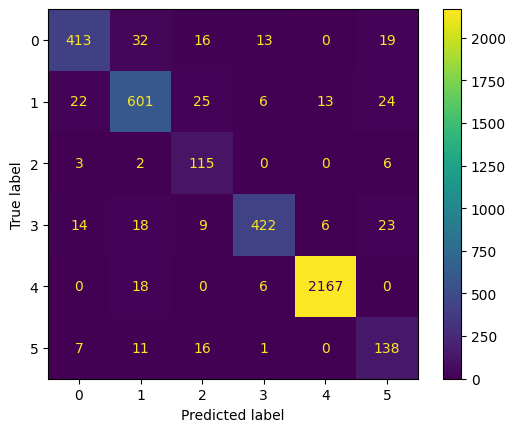

In [36]:
# Plot the confusion matrix for the Balanced Random Forest
cm=confusion_matrix(test_labels,y_pred_BRF,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# Random Forest

Parameter didn't change after tuning


In [37]:
# Create a Random Forest classifier object with best parameters found via grid search
clf_RF = RandomForestClassifier(random_state=0)

# Train the Random Forest Classifier
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_RF = clf_RF.predict(test_features)

In [38]:
# Get the metrics for the Random Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       493
           1       0.89      0.92      0.90       691
           2       0.72      0.77      0.75       126
           3       0.94      0.87      0.90       492
           4       0.99      1.00      0.99      2191
           5       0.72      0.73      0.72       173

    accuracy                           0.94      4166
   macro avg       0.86      0.86      0.86      4166
weighted avg       0.94      0.94      0.94      4166



In [39]:
# Get macro average F1 score
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.8578255385994162

In [40]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.9039618959511456

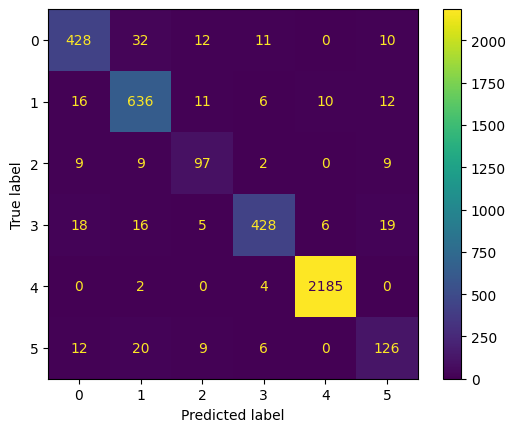

In [42]:
# Plot the confusion matrix for the Random Forest
cm=confusion_matrix(test_labels,y_pred_RF,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# Extra trees

Parameter didn't change after tuning


In [43]:
# Create an Extra Trees classifier object
clf_ET = ExtraTreesClassifier(n_jobs=-1,random_state=0)

# Train Extra Trees Classifier
clf_ET = clf_ET.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_ET = clf_ET.predict(test_features)

In [44]:
# Get the metrics for the Extra Trees
print(classification_report(test_labels,y_pred_ET))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       493
           1       0.90      0.93      0.92       691
           2       0.71      0.74      0.72       126
           3       0.93      0.88      0.91       492
           4       0.99      1.00      1.00      2191
           5       0.74      0.73      0.73       173

    accuracy                           0.94      4166
   macro avg       0.86      0.86      0.86      4166
weighted avg       0.94      0.94      0.94      4166



In [45]:
# Get macro average F1 score
f1_ET = f1_score(test_labels, y_pred_ET, average='macro')
f1_ET

0.8591503812983269

In [46]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_ET = matthews_corrcoef(test_labels, y_pred_ET)
MCC_ET

0.9089987281978014

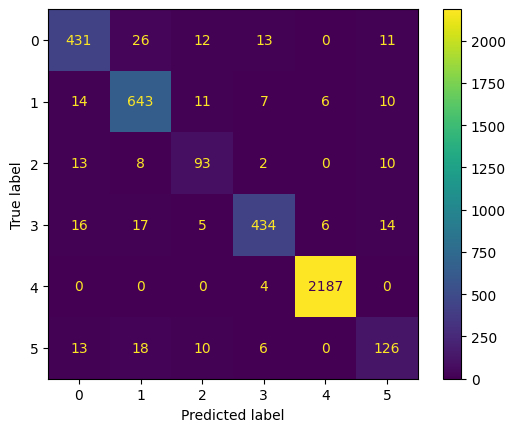

In [47]:
# Plot the confusion matrix for the Extra Trees
cm=confusion_matrix(test_labels,y_pred_ET,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# SVC


In [58]:
# Create an SVC classifier object
clf_SVC = SVC(kernel='rbf', C=100000,random_state=0)

# Train the SVC Classifier
clf_SVC = clf_SVC.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_SVC = clf_SVC.predict(test_features)

In [59]:
# Get the metrics for the SVC
print(classification_report(test_labels,y_pred_SVC))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       493
           1       0.86      0.87      0.87       691
           2       0.68      0.82      0.74       126
           3       0.91      0.87      0.89       492
           4       0.99      0.99      0.99      2191
           5       0.66      0.69      0.68       173

    accuracy                           0.92      4166
   macro avg       0.82      0.84      0.83      4166
weighted avg       0.92      0.92      0.92      4166



In [60]:
# Get macro average F1 score
f1_SVC = f1_score(test_labels, y_pred_SVC, average='macro')
f1_SVC

0.8323283008873704

In [61]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_SVC = matthews_corrcoef(test_labels, y_pred_SVC)
MCC_SVC

0.8762318915821349

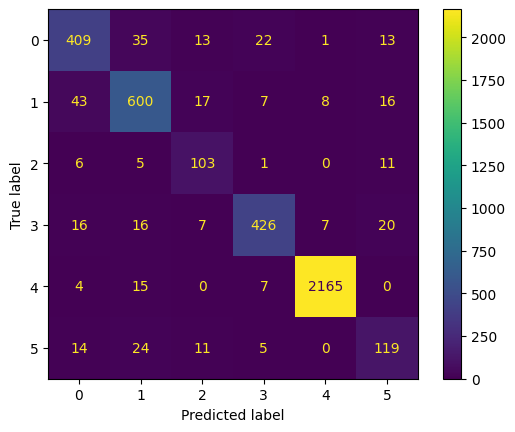

In [62]:
# Plot the confusion matrix for the SVC
cm=confusion_matrix(test_labels,y_pred_SVC,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# Cat Boost


In [52]:
clf_cat = CatBoostClassifier(loss_function='MultiClass', random_seed=0)
clf_cat.fit(train_features, train_labels, verbose=False)

In [53]:
y_pred_cat = clf_cat.predict(test_features)
y_pred_cat

array([[1],
       [0],
       [4],
       ...,
       [4],
       [1],
       [1]], dtype=int64)

In [54]:
print(classification_report(test_labels,y_pred_cat))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       493
           1       0.88      0.91      0.89       691
           2       0.73      0.81      0.77       126
           3       0.94      0.87      0.90       492
           4       0.99      1.00      0.99      2191
           5       0.70      0.69      0.69       173

    accuracy                           0.93      4166
   macro avg       0.85      0.85      0.85      4166
weighted avg       0.93      0.93      0.93      4166



In [55]:
# Get macro average F1 score
f1_CAT= f1_score(test_labels, y_pred_cat, average='macro')
f1_CAT

0.8524240675005018

In [56]:
MCC_CAT = matthews_corrcoef(test_labels, y_pred_cat)
MCC_CAT

0.8974586622703983

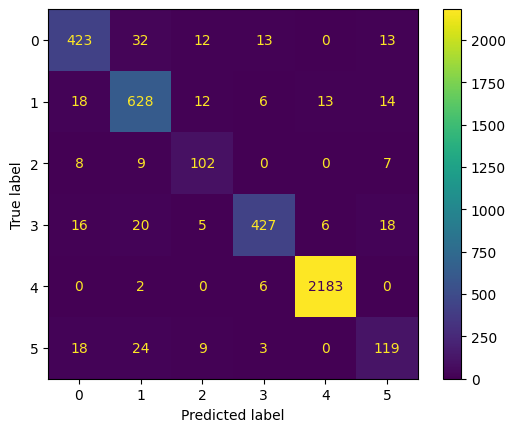

In [57]:
# Plot the confusion matrix for Catboost
cm=confusion_matrix(test_labels,y_pred_cat,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# LightGBM 

Parameter didn't change after tuning


In [63]:
clf_gbm=lgb.LGBMClassifier(random_state=0)
clf_gbm.fit(train_features,train_labels)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 16663, number of used features: 10
[LightGBM] [Info] Start training from score -2.161386
[LightGBM] [Info] Start training from score -1.791100
[LightGBM] [Info] Start training from score -3.400178
[LightGBM] [Info] Start training from score -2.188858
[LightGBM] [Info] Start training from score -0.644366
[LightGBM] [Info] Start training from score -3.043863


LGBMClassifier(random_state=0)

In [64]:
y_pred_gbm = clf_gbm.predict(test_features)
y_pred_gbm

array([1, 0, 4, ..., 4, 1, 1], dtype=int64)

In [65]:
print(classification_report(test_labels,y_pred_gbm))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       493
           1       0.88      0.92      0.90       691
           2       0.71      0.76      0.73       126
           3       0.94      0.87      0.90       492
           4       0.99      1.00      1.00      2191
           5       0.73      0.70      0.72       173

    accuracy                           0.93      4166
   macro avg       0.85      0.85      0.85      4166
weighted avg       0.94      0.93      0.93      4166



In [66]:
# Get macro average F1 score
f1_GBM = f1_score(test_labels, y_pred_gbm, average='macro')
f1_GBM

0.8532582212399111

In [67]:
MCC_GBM = matthews_corrcoef(test_labels, y_pred_gbm)
MCC_GBM

0.9014882400516937

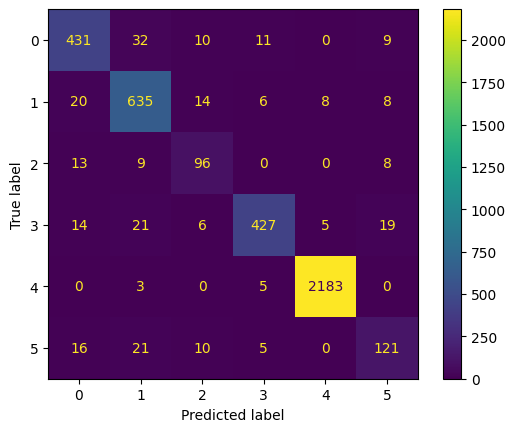

In [68]:
# Plot the confusion matrix for Light Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_gbm,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

## Extreme Gradient Boost


In [74]:
clf_xgb=xgb.XGBClassifier(objective='multi:softprob',random_state=0, verbosity=0);
clf_xgb.fit(train_features,train_labels);

In [75]:
y_pred_xgb = clf_xgb.predict(test_features)
y_pred_xgb

array([1, 0, 4, ..., 4, 1, 1], dtype=int64)

In [76]:
print(classification_report(test_labels,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       493
           1       0.88      0.91      0.90       691
           2       0.71      0.77      0.74       126
           3       0.93      0.86      0.89       492
           4       0.99      1.00      1.00      2191
           5       0.73      0.69      0.71       173

    accuracy                           0.93      4166
   macro avg       0.85      0.85      0.85      4166
weighted avg       0.93      0.93      0.93      4166



In [77]:
f1_XGB = f1_score(test_labels, y_pred_xgb, average='macro')
f1_XGB

0.8501421743954426

In [78]:
MCC_XGB = matthews_corrcoef(test_labels, y_pred_xgb)
MCC_XGB

0.8982032110294411

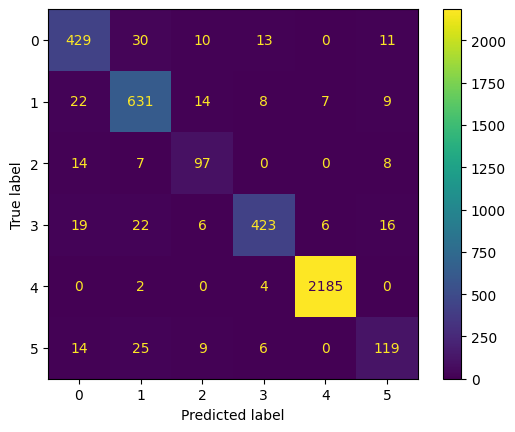

In [79]:
# Plot the confusion matrix for Extreme Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_xgb,labels=[0,1,2,3,4,5])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot();

# Comparison tables

Cells below contain code to create a nice-looking table which compares F1, AUC and MCC of all algorithms used in OBerA.


In [81]:
# Create a skeleton of the table
comp_table = pd.DataFrame(index=['Neural Network', 'SVC', 'Decision Tree', 'Balanced Random Forest', 'Random Forest', 'Extra Trees','Catboost','LightGBM','XGBoost'], columns=['F1 score', 'MCC'])

In [82]:
# Add values to the table
comp_table.iloc[0] = [f1_NN, MCC_NN]
comp_table.iloc[1] = [f1_SVC, MCC_SVC] 
comp_table.iloc[2] = [f1_DT, MCC_DT]
comp_table.iloc[3] = [f1_BRF, MCC_BRF]
comp_table.iloc[4] = [f1_RF, MCC_RF]
comp_table.iloc[5] = [f1_ET, MCC_ET]
comp_table.iloc[6] = [f1_CAT, MCC_CAT]
comp_table.iloc[7] = [f1_GBM, MCC_GBM]
comp_table.iloc[8] = [f1_XGB, MCC_XGB]

In [83]:
# Round all the values down to two digits
for i in range(len(comp_table)):
    comp_table.iloc[i] = comp_table.iloc[i].apply(lambda x: round(x, 5))

In [84]:
# Show the table
comp_table

,F1 score,MCC
Neural Network,0.82653,0.8755
SVC,0.83233,0.87623
Decision Tree,0.83123,0.8846
Balanced Random Forest,0.85016,0.88886
Random Forest,0.85783,0.90396
Extra Trees,0.85915,0.909
Catboost,0.85242,0.89746
LightGBM,0.85326,0.90149
XGBoost,0.85014,0.8982
